## Hamiltonian Monte Carlo

<br>

The MCMC samplers that we have discussed so far can be thought of as a guided random walk towards regions of high posterior density. This random walk behaviour is inherently **inefficient**. Model reparametrisation and other tricks can help to improve the situation, but the inefficiency remains, **especially in high-dimensional problems**.

<br>

**Hamiltonian Monte Carlo (HMC)** is a dramatically more efficient way to draw samples from the target posterior distribution, thanks to its departure from the random walk approach. Instead, HMC uses concepts from Hamiltonian mechanics to direct the Markov transitions and avoid diffusive behaviour.

<br>

An excellent introduction to HMC that is suitable for researchers in the physical sciences can be found in [this paper](https://arxiv.org/pdf/1701.02434.pdf) by Michael Betancourt. Here, I will try to summarise the main concepts, borrowing notation, figures and explanations from this work.


### Computing expectations with MCMC

<br>

The goal in the implementation of any MCMC algorithm is the computation of expectation values. Consider a target sample space $Q$, of which any point $q \in Q$ can be parametrised by real numbers, in $D$ dimensions. In this parameter space, let our target distribution be a smooth density function, $\pi(q)$. 

<br>

Computing expectation values over this distribution is done by integrating over the parameter space

<br>

$$
\mathbb{E}_\pi[f] = \int_Q \mathrm{d}q~\pi(q)f(q).
$$

<br>

In practice, we approximate these integrals through the Markov chains returned by our samplers.

<br>

Given that we want to compute expectations, an obvious way for our sampler to be inefficient is to **waste time evaluating $\pi(q)$ in regions of parameter space that have negligible contribution to the expectation.**

<br>

So we should just focus on regions with large density, $\pi(q)$, right? *Not exactly*. The expectation is an *integral* of this density of the *volume*, $\mathrm{d}q$. While the density will be largest at the mode, there is relatively little volume here, especially in high dimensions. Recall the curse of dimensionality as illustrated in the figure below. The relative weight of a partition containing a point of interest decreases from $1/3$ to $1/9$ and $1/27$ as we scale from 1 to 3 dimensions.

<br>

<img src="img/hmc1.png" alt="The curse of dimensionality" width="800"/>

<br>

Actually, volume will be largest in the tails of the distribution, away from the mode. If we have $\pi(q)$ largest at the mode, and $\mathrm{d}q$ largest in the tails, the region of interest is somewhere between the two. Let's refer to this region as the **typical set**.

<br>

<img src="img/hmc2.png" alt="The typical set" width="500"/>

<br>

So we have understood that we want to focus all our computational resources on exploring this typical set. As we discussed above, standard MCMC algorithms, such as the Metropolis-Hastings algorithm, will eventually explore the typical set, as long as the Markov transition *preserves* the target distribution. 

<br>

Given sufficient time, samples from the Markov chain can be used to approximate our desired expectations:

<br>

$$
\hat{f}_N = \frac{1}{N} \sum_{n=0}^N f(q_n),
$$
and
$$
\lim_{N\to\infty} \hat{f}_N = \mathbb{E}_\pi[f].
$$

### The basics of HMC

<br>

So how can we explore the typical set more efficiently than with just randomly walking? We can exploit information about the *geometry* of the typical set, and use this to move through it. Imagine that we knew the *vector field* of the typical set, we could just follow it, like a ball rolling along a slope.

<br>

Great! But how can we find this vector field using only information about our target density? The *gradient* of the density will give us a vector field that points towards the mode, but we want to move around the mode in the typical set. We can imagine this as a physical system, like a satellite (our trajectory) in orbit around the Earth (the mode):

<br>

<img src="img/hmc3.png" alt="Exploring the typical set" width="900"/>

<br>

We too can avoid "crashing into the mode" by giving our "satellite" enough momentum. But we don't want to add too much or too little momentum either. Let's start by expanding our parameter space by introducing auxiliary momentum parameters, $p$

<br>

$$
q \rightarrow (q, p).
$$

<br>

In doing this, our target distribution is now a joint probability distrbution over $p$ and $q$. We can express this as

<br>

$$
\pi(q, p) = \pi(p|q)\pi(q).
$$

<br>

This choice ensure that if we marginalise out the momentum, we immediately recover what we started with. Any trajectory in this new joint space can therefore be projected down into our original parameter space.

<br>

Continuing the analogy with classical mechanics, we can now use Hamiltonian dynamics to construct trajectories in the joint space. The Hamiltonian energy of the system

<br>

$$
H(q, p) \equiv -\log\pi(q, p),
$$

<br>

is composed of two terms

<br>

$$
H(q, p) = - \log\pi(p|q) - \log\pi(q) \equiv K(p, q) + V(q),
$$

<br>

with $K(p, q)$ and $V(q)$ the kinetic and potential energies, respectively. The potential energy is set by the target distribution, whereas the kinetic energy is to be determined.

The Hamiltonian contains the geometry of the typical set, and so we can use it to find a vector field aligned with the typical set via **Hamilton's equations**,

<br>

$$
\frac{\mathrm{d}q}{\mathrm{d}t} = \frac{\partial H}{\partial p} = \frac{\partial K}{\partial p}
$$

$$
\frac{\mathrm{d}p}{\mathrm{d}t} = - \frac{\partial H}{\partial q} = - \frac{\partial K}{\partial q} - \frac{\partial V}{\partial q}.
$$

<br>

Here we recognise $\partial V / \partial q$ as simply the gradient of our target distribution, satisfying our above physical intuition.

> Evolving Hamilton's equations for some time generates trajectories in the joint space that efficiently move around the typical set. Projecting these trajectories back into our parameter space via marginalisation gives what we set out to find!

<u>The Hamiltonian Markov transition</u>
* Lift a point into the joint space from the parameter space by sampling from the conditional distribution
$$
p \sim \pi(p | q).
$$
* Integrate Hamilton's equations for some time, $t$, to move around the typical set
$$
(q, p) \rightarrow \phi_t(q, p).
$$
* Project back down into parameter space via marginalisation
$$
(q, p) \rightarrow q.
$$

### Tuning

<br>

In our above explanation, we left two quantities to be determined:
* The **kinetic energy** $\sim \pi(p|q)$.
* The **integration time**, $t$.

These degrees of freedom need to be tuned to suit our particular problem. 

<br>

<u>Optimising the kinetic energy</u>

Each time we sample a new momentum, we enter a different *energy level* of the system. For efficient exploration, we want to explore different energy levels in a uniform way, and for our momentum sampling to imply energy sampling that is close to that of the marginal energy distribution of the system. I.e.

<br>

$$
\pi(p|q) \Rightarrow \pi(E|q),
$$
and we want 
$$
\pi(E|q) \sim \pi(E).
$$

<br>

As there are an infinite number of possible kinietic energies, it makes sense to restrict our search. A standard choice are *Euclidean-Gaussian* kinetic energies, such that

<br>

$$
\pi(p|q) = \mathcal{N}(p | 0, M),
$$

<br>

where $M$ is typically referred to as the *mass matrix*. Because of the dual behaviour between the momentum and parameters, it turns out we can define an optimal choice for $M$ by setting its inverse equal to the *target covariances*. In practice, this is estimated during the warmup phase of an HMC algorithm implementation.

<br>

<u>Optimising the integration time</u>

If we integrate for short times, we won't explore so far away, but if we integrate for too long, we will end up revisiting regions that have already been explored. The optimal choice will depend on the kinetic energy and where in the joint space the transition occurs. 

A practical solution to this is the [*No-U-Turn*](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf) trajectory termination criterion that allows the intergation time to be chosen dynamically. Samplers implementing this criterion are often reffered to as No-U-Turn samplers, or NUTS. 

### Implementation

<br>

In practice, we have to solve Hamilton's equations *numerically*. This leads to inaccuracies that add with integration time and scale with the number of dimensions. The geometry of the problem motivates the choice of **Symplectic integrators** for which the errors at least oscillate around the true values. Another aspect of their performance is that in regions of extreme curvature, the numerical trajectories diverge to infinity.

<br>

<img src="img/hmc4.pdf" alt="Divergent transitions" width="900"/>

<br>

While this may seem like a bad thing, the existence and location of **divergent transitions** is actually a very helpful diagnostic when implementing HMC in practice.

We can also correct for the error induced by integration by defining a **reversible transition** (positive and negative momentum) and introducing an **accept/reject Metropolis step**, as the acceptance probability can be calculated exactly from the Hamiltonian.

As we integrate numerically, the integration time becomes defined by a **step size** and **number of steps**. The step size can be optimised during the warmup phase, by defining a target metropolis acceptance rate (typically around 0.8). The number of steps, or trajectory length, is optimised dynamically during sampling via the No-U-Turn criterion mentioned above.

<br>

<u>Stan</u>

[Stan](https://mc-stan.org) is a software platform with a robust implementation of an adaptive HMC algorithm, including NUTS. Given a model specification and data, Stan will automatically optimise the *mass matrix* and *step size*, letting you focus on your model and inferences.

We will work more with Stan in the second block of the course as a tool for implementing a Bayesian workflow.

### Diagnostics

<br>

Like any MCMC algorithm, the **effective sample size** and **Gelman-Rubin statistic** can be used to judge the within-chain correlation and convergence of chains. The implementation of HMC also permits two new diagnostic tools:

* **Divergent transitions:** As mentioned above, in regions of high curvature the results of numerical integration will diverge. We can use divergent transitions to notify us of the presence and also location of regions of high curvature.

* **E-BFMI:** The energy Bayesian fraction of missing information quantifies the mismatch between $\pi(E|q)$ and $\pi(E)$, allowing us to diagnose poorly-chosen kinetic energies. If the E-BFMI is below around 0.3, it seems that the warmup is unable to find a decent mass matrix for the presented problem.

<br>

If these kind of divergences are encountered, it is likely that some form of model reparametrisation can help out.

### Visualisation

<br>

A nice visualisation of HMC and other algorithms can be found [here](https://chi-feng.github.io/mcmc-demo/app.html), by Chi Feng. 

### Demonstration

<br>

We can demonstrate the power of these diagnostics with using Stan and the classic *Eight schools problem*. See Section 5.5. of [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al. for more information.

In summary, the goal is to understand the impact of extra coaching programs on student grades, conducted in parallel in $J=8$ different schools. For each school, we have an estimated impact $y_j$, and a standard error of this estimate, $\sigma_j$. 

Let's say we want to consider the data from all schools in our final conclusion. We think the schools and coaching programs are similar, but admit they are not identical. To capture this, we use a **hierarchical normal model**.

>We will discuss hierarchical models more in block II of this course.

We introduce parameters $\mu$ and $\tau$ to describe the average impact and variance across all schools. Each school has a true impact $\theta_j$, and an observed impact $y_j$, as introduced above.

<br>

<img src="img/8schools.pdf" alt="The eight schools model" width="700"/>

<br>

The initial model is given in `stan/schools.stan`, and the data are introduced below.

In [1]:
import numpy as np
import arviz as av
from cmdstanpy import CmdStanModel

In [2]:
!cat stan/schools.stan

data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);

  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}


In [3]:
model = CmdStanModel(stan_file="stan/schools.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/fran/projects/bayesian_workflow_prep/stan/schools


In [4]:
data = {}
data["J"]= 8
data["y"] = [28, 8, -3, 7, -1, 1, 18, 12] 
data["sigma"] = [15, 10, 16, 11, 9, 11, 10, 18]

In [5]:
fit = model.sample(data=data, iter_sampling=1000, chains=4, seed=42)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [6]:
fit.diagnose()
fit.summary()

INFO:cmdstanpy:Processing csv files: /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools-202109021959-1-a16ki1ig.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools-202109021959-2-1s8521o3.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools-202109021959-3-4mkm3lm7.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools-202109021959-4-sm8ngg5r.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
84 of 4000 (2.1%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.25, is below the nominal threshold of 0.3 which suggests that HMC may have trouble exploring t

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-15.0,0.45,6.0,-25.00,-15.0,-5.2,180.0,820.0,1.0
mu,4.4,0.11,3.1,-0.73,4.4,9.6,790.0,3600.0,1.0
tau,3.8,0.17,3.0,0.84,3.0,9.9,310.0,1400.0,1.0
theta[1],6.1,0.16,5.3,-1.40,5.5,16.0,1089.0,4995.0,1.0
theta[2],4.9,0.12,4.6,-2.30,4.8,13.0,1475.0,6764.0,1.0
theta[3],4.0,0.13,4.9,-4.00,4.3,12.0,1483.0,6801.0,1.0
theta[4],4.8,0.13,4.7,-2.80,4.9,12.0,1433.0,6572.0,1.0
theta[5],3.5,0.14,4.5,-4.30,3.9,10.0,1036.0,4753.0,1.0
theta[6],4.0,0.12,4.7,-3.50,4.3,11.0,1559.0,7153.0,1.0



Note the presence of divergent transitions and low E-BFMI. Let's visualise the location of the divergent transitions.

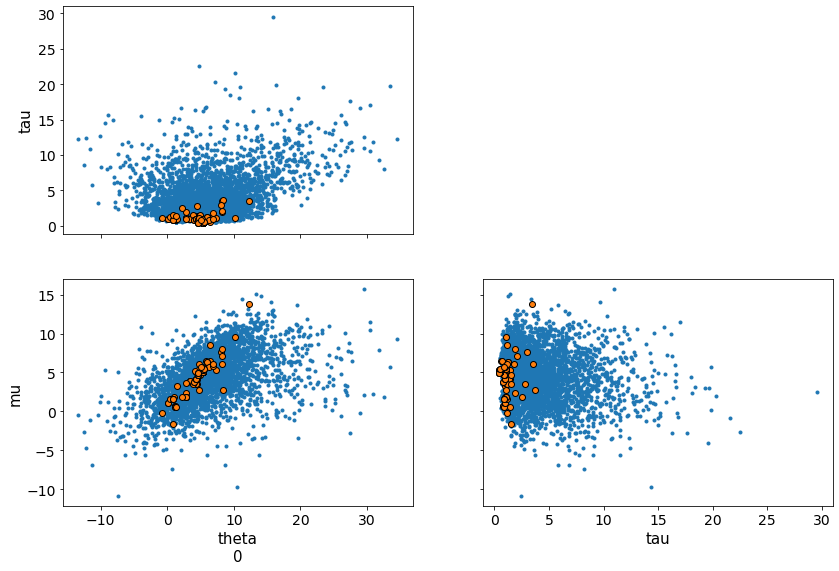

In [7]:
fit_a = av.from_cmdstanpy(fit, coords={"J" : np.arange(data["J"])}, 
                          dims={"theta": ["J"]})
av.plot_pair(fit_a, var_names=["theta", "tau", "mu"], 
             divergences=True, coords={"J": np.array([0])});

We see that the divergent transitions are clustered around small tau values before an abrupt stop. This indicates a funnel geometry that the sampler is not able to penetrate.

<br>

This is a well-known problem for models of this type. We can try to reparametrise our model using a [non-centred parametrisation](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html). We can introduce $\theta^\prime$ such that

<br>

$$
\theta = \mu + \tau \theta^\prime,
$$
$$
p(\theta^\prime | \mu, \tau) = \mathcal{N}(0, 1).
$$

<br>

This is implemented in the `stan/schools_nc.stan` model.

In [8]:
!cat stan/schools_nc.stan 

data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_prime[J];
}

transformed parameters {
  real theta[J];

  for (j in 1:J)
    theta[j] = mu + tau * theta_prime[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);

  theta_prime ~ normal(0, 1);
  y ~ normal(theta, sigma);
}


We can now try to fit this model instead...

In [9]:
model_nc = CmdStanModel(stan_file="stan/schools_nc.stan")
fit_nc = model_nc.sample(data=data, iter_sampling=1000, chains=4, seed=42)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/fran/projects/bayesian_workflow_prep/stan/schools_nc
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [10]:
fit_nc.diagnose()
fit_nc.summary()

INFO:cmdstanpy:Processing csv files: /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools_nc-202109021959-1-l88z3sq5.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools_nc-202109021959-2-fu__im24.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools_nc-202109021959-3-aban8y1p.csv, /var/folders/8d/cyg0_lx54mggm8v350vlx91r0000gn/T/tmpzj3y24z3/schools_nc-202109021959-4-jbwdsw96.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-6.900,0.061,2.40,-11.00,-6.500,-3.6,1500.0,9200.0,1.0
mu,4.400,0.052,3.30,-1.10,4.400,9.6,4000.0,24000.0,1.0
tau,3.600,0.059,3.20,0.23,2.900,10.0,3000.0,18000.0,1.0
theta_prime[1],0.310,0.015,0.96,-1.20,0.310,1.9,4289.0,26151.0,1.0
theta_prime[2],0.086,0.015,0.94,-1.50,0.097,1.6,4219.0,25729.0,1.0
theta_prime[3],-0.084,0.014,0.95,-1.60,-0.082,1.5,4489.0,27371.0,1.0
theta_prime[4],0.045,0.015,0.94,-1.50,0.037,1.6,3772.0,23001.0,1.0
theta_prime[5],-0.160,0.013,0.93,-1.70,-0.160,1.4,5229.0,31884.0,1.0
theta_prime[6],-0.073,0.014,0.94,-1.60,-0.070,1.5,4289.0,26152.0,1.0


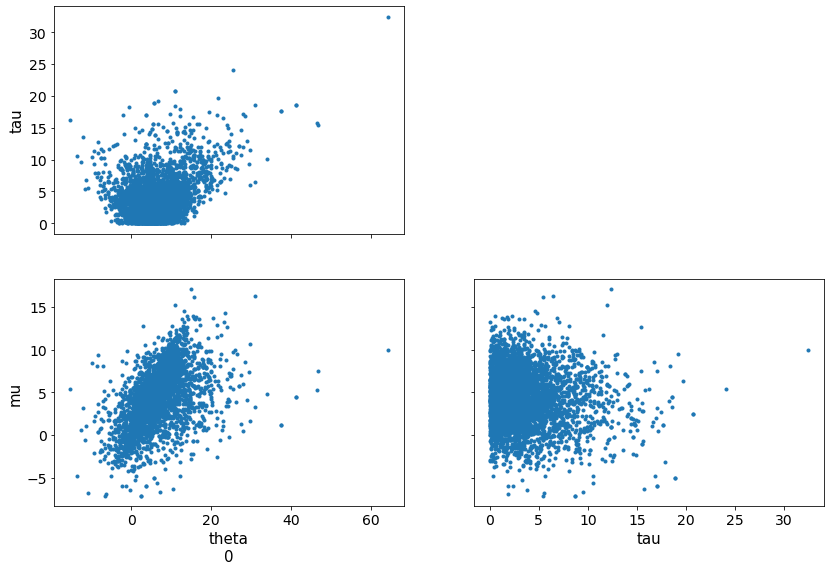

In [11]:
fit_a_nc = av.from_cmdstanpy(fit_nc, coords={"J" : np.arange(data["J"])}, 
                          dims={"theta": ["J"]})
av.plot_pair(fit_a_nc, var_names=["theta", "tau", "mu"], 
             divergences=True, coords={"J": np.array([0])});

### Further reading

* Michael Betancourt's [*A Conceptual Introduction to Hamiltonian Monte Carlo*](https://arxiv.org/pdf/1701.02434.pdf), on which the above is based.
* A more mathematical approach: Betancourt at al. (2017) [The geometric foundations of Hamiltonian Monte Carlo](https://projecteuclid.org/journals/bernoulli/volume-23/issue-4A/The-geometric-foundations-of-Hamiltonian-Monte-Carlo/10.3150/16-BEJ810.full), Bernoulli 23(4A), 2257-2298.
* The No-U-Turn algorithm: Gelman et al. (2014) [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf), Journal of Machine Learning Research 15, 1593-1623.
* The [Stan website](https://mc-stan.org).
* The eight schools problem: Section 5.5 of [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) by Gelman et al. 